In [266]:
! git clone -b tfh-new https://github.com/AugustSchreyer/02460_Advanced_ML.git

Cloning into '02460_Advanced_ML'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 119 (delta 51), reused 91 (delta 26), pack-reused 0
Receiving objects: 100% (119/119), 73.57 MiB | 33.92 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [267]:
import torch

import copy
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import dill
from generators.generate_data_tfh import SERSGenerator
from VAE.models import BaseLSTM_VAEprob


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [268]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [269]:
os.chdir("02460_Advanced_ML")

In [270]:
os.listdir()

['.git',
 'generators',
 'Basic model test',
 'links.txt',
 'raman_spectre_model.ipynb',
 'LSTM-VAE-DISCOVERY.ipynb',
 'VAE',
 'articles',
 'tfh-generator.pkl',
 '.gitignore',
 'raman_spectre_model-test.ipynb',
 'tfh-generator1.pkl',
 'README.md']

In [271]:
with open("tfh-generator1.pkl", 'rb') as f:
    generator = dill.load(f)

In [17]:
df = pd.DataFrame(generator.X)

In [18]:
train_df, val_df = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

In [19]:
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()

    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [20]:
train_dataset, seq_len, n_features = create_dataset(df)
train_dataset = train_dataset[:500]
#val_dataset, _, _ = create_dataset(val_df)

In [21]:
print(f"Length of each spectre: {seq_len}")
print(f"Number of features: {n_features}")

Length of each spectre: 120
Number of features: 1


In [22]:
bool_mat = np.zeros((40,40))
bool_mat[3, 10] = 1
idx = np.where(bool_mat.reshape(-1) == 1)[0]

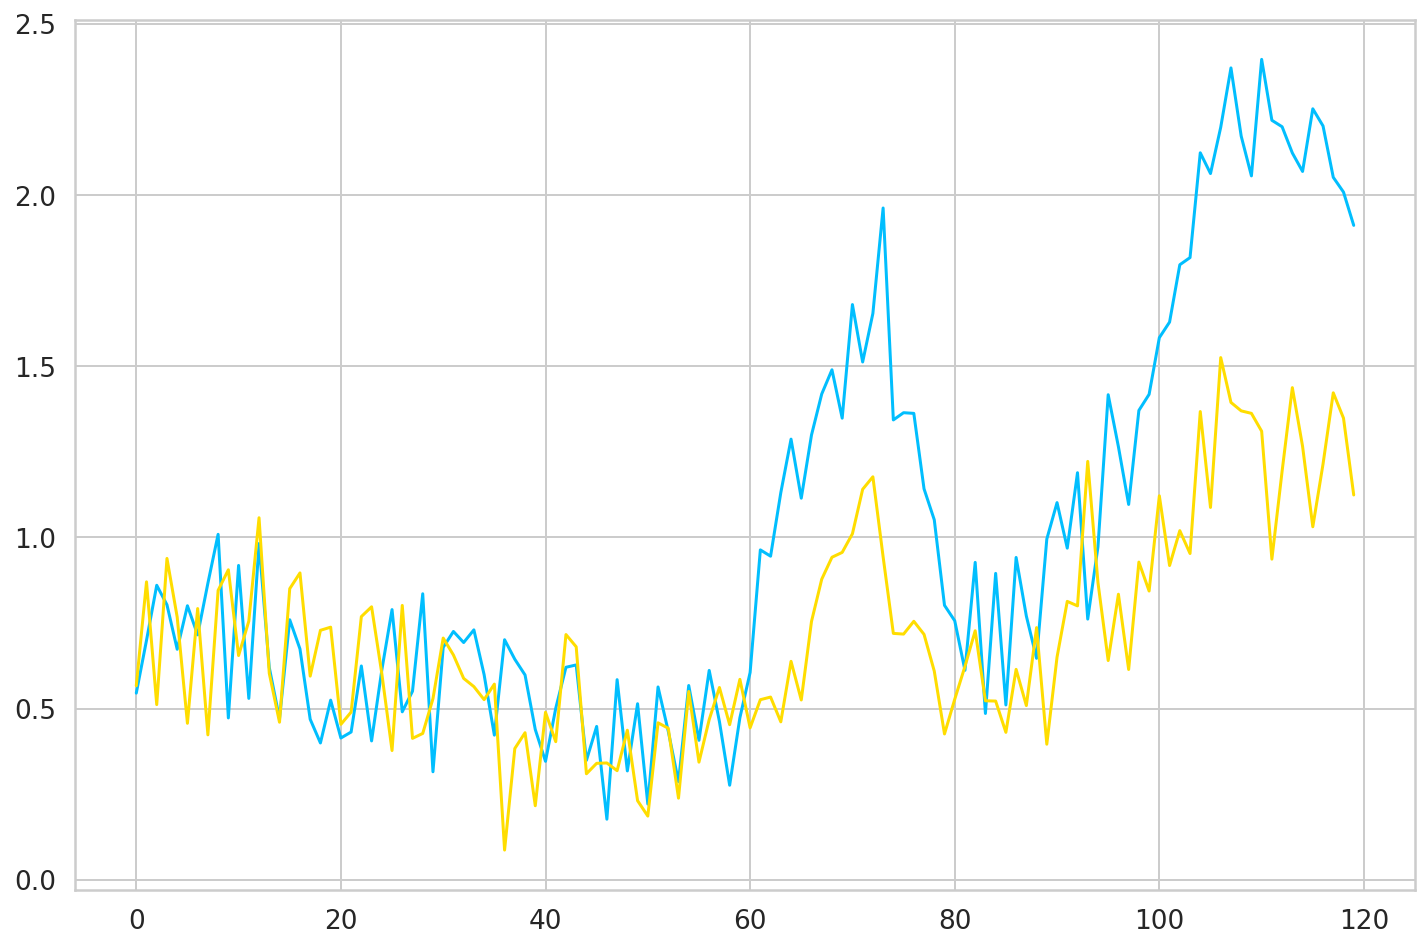

In [23]:
plt.plot(train_dataset[idx[0]])
plt.plot(train_dataset[3])

In [148]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, hidden_dim=50, latent_features=16, num_layers=1, bidirectional=True):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.latent_features = latent_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        torch.manual_seed(0)
        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        self.fc1 = nn.Linear(
            in_features=self.hidden_dim + int(self.bidirectional) * self.hidden_dim,
            out_features=100)
        
        self.fc2 = nn.Linear(
            in_features=100,
            out_features=2*latent_features)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape((-1, self.seq_len, self.n_features))

        #(batch, hidden)
        x, (hidden_n, _) = self.lstm(x)
        #print()
        #print("hidden encoder")
        #print(hidden_n.shape)
        #print(hidden_n[0, 0, :5])
        #print(hidden_n[1, 0, :5])
        #print(hidden_n[2, 0, :5])
        #print(hidden_n[3, 0, :5])

        if self.bidirectional:
            hidden_n = torch.cat([hidden_n[-1,:, :], hidden_n[-2,:,:]], dim=1).unsqueeze(0)
        else:
            hidden_n = hidden_n[-1, :, :]
        
        #print(hidden_n.shape)

        hidden_n = hidden_n.reshape(batch_size, -1)
        
        #(batch, hidden) -> (batch, 2*latent)
        x = self.fc1(hidden_n)
        x = self.fc2(self.relu(x))

        return x.view(-1, 2*self.latent_features)

In [149]:
class Decoder(nn.Module):

    def __init__(self, seq_len, n_features=1, hidden_dim=50, latent_features=16, num_layers=1, bidirectional=True):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim, self.n_features = hidden_dim, n_features
        self.latent_features = latent_features
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm_depth = self.num_layers + self.num_layers * int(self.bidirectional)
        
        self.latent_to_hidden = nn.Linear(self.latent_features, self.hidden_dim)
        self.hidden_to_mu = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        self.hidden_to_sig = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        
        
        self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.cuda.FloatTensor)
        self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.cuda.FloatTensor)


        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        
        
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # https://github.com/hellojinwoo/TorchCoder/blob/master/autoencoders/rae.py
        # THIS LAYER CAN BE EXCLUDED
        batch_size = x.size(0)
        h_state = self.latent_to_hidden(x)
        
        
        h_0 = torch.stack([h_state for _ in range(self.lstm_depth)])
        #print(f"h_0: {h_0.shape}")
        inputs = torch.stack([self.decoder_inputs for _ in range(batch_size)])
        #print(f"inputs: {inputs.shape}")
        c_inp = torch.stack([self.c_0 for _ in range(batch_size)]).permute(1,0,2).contiguous()
        #print(f"c_inp: {c_inp.shape}")
        
        decoder_output, _ = self.lstm(inputs, (h_0, c_inp))
        #print(f"DECOER OUTPUT: {decoder_output.shape}")
        
        
        out_mu = self.hidden_to_mu(decoder_output).squeeze(-1)
        out_sig = self.hidden_to_sig(decoder_output).squeeze(-1)
        
        out = torch.cat([out_mu, out_sig], axis=1)
        #print(out.shape)
        
        return out

In [312]:
loc = np.array([
    [5, 3],
    [8, 9]
])
c_norm = np.array([25, 75])
c_outlier = np.array([10, 45])
gen_data = SERSGenerator([10, 10], 120, hotspot_loc=loc, c=c_norm, seed=42)
gen_outlier = SERSGenerator([10, 10], 120, hotspot_loc=loc, c=c_outlier, seed=42)

train_dataset = []
outlier_dataset = []


for i in range(15):

    X = gen_data.generate(N_hotspots=gen_data.hotspot_loc.shape[0], sig=0.1, sbr=1.5, K=len(gen_data.c), plot=False)

    X = torch.from_numpy(X).float()

    train_dataset.append(X)

    if i == 0:
        X_outlier = gen_outlier.generate(N_hotspots=gen_outlier.hotspot_loc.shape[0], sig=0.1, sbr=1.5, K=len(gen_outlier.c), plot=False)
        X_outlier = torch.from_numpy(X_outlier).float()
        outlier_dataset.append(X_outlier)

        gen_data.seed = None
        gen_outlier.seed = None

        

train_dataset = torch.cat([s for s in train_dataset])
train_dataset = train_dataset.unsqueeze(2)

outlier_dataset = torch.cat([s for s in outlier_dataset])
outlier_dataset = outlier_dataset.unsqueeze(2)

In [313]:
LATENT_FEATURES = 8
HIDDEN_DIM = 100
NUM_LAYERS = 2
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
bidirectional = True
BETA = 0.01

encoder = Encoder(seq_len, n_features=1, hidden_dim=HIDDEN_DIM, latent_features=LATENT_FEATURES, num_layers=NUM_LAYERS, bidirectional=bidirectional).to(device)
decoder = Decoder(seq_len, n_features=1, hidden_dim=HIDDEN_DIM, latent_features=LATENT_FEATURES, num_layers=NUM_LAYERS, bidirectional=bidirectional).to(device)
model = BaseLSTM_VAEprob(latent_features=LATENT_FEATURES, encoder=encoder, decoder=decoder, beta=BETA).to(device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#FOR NOW VALIDATION IS SAME AS TRAINING...
validation_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [314]:
NUM_EPOCHS = 1000
LOSS_LIST = []
KL_LOSS_LIST = []
RECON_LOSS_LIST = []
VAL_LOSS_LIST = []
for epoch in range(1, NUM_EPOCHS+1):
    running_loss = 0
    running_loss_kl = 0
    running_loss_recon = 0
    count = 0
    model.train()

    if epoch > 300:
        model.beta = 10 * epoch / NUM_EPOCHS

    for batch in train_loader:
        count += len(batch)/BATCH_SIZE
        batch = batch.to(device)

        loss, diagnostics, outputs = model.elbo(batch)
        running_loss -= loss.item()
        running_loss_kl += diagnostics["kl"].mean()
        running_loss_recon += diagnostics["log_px"].mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss_epoch = running_loss/count
    LOSS_LIST.append(avg_loss_epoch)
    
    kl_loss_epoch = running_loss_kl/count
    KL_LOSS_LIST.append(kl_loss_epoch)
    
    recon_loss_epoch = running_loss_recon/count
    RECON_LOSS_LIST.append(recon_loss_epoch)
    
    with torch.no_grad():
        model.eval()
        
        # Just load a single batch from the test loader
        x = next(iter(validation_loader))
        x = x.to(device)
        val_loss, _, _ = model.elbo(x)
    
    VAL_LOSS_LIST.append(-val_loss.item())
    
    if epoch % 25 == 0:
        print(f"epoch {epoch}")
        print(f"Average loss: {np.mean(LOSS_LIST[-25:])}")
        print(f"Validation loss: {np.mean(VAL_LOSS_LIST[-25:])}")


epoch 25
Average loss: -2.116501923421224
Validation loss: 0.06351798057556152
epoch 50
Average loss: 85.03356114420575
Validation loss: 84.14338523864745
epoch 75
Average loss: 137.05665799804686
Validation loss: 134.59624176025392
epoch 100
Average loss: 174.42011250000004
Validation loss: 170.36992095947267
epoch 125
Average loss: 159.5527722294108
Validation loss: 161.2743445777893
epoch 150
Average loss: 222.41050546875
Validation loss: 218.988154296875
epoch 175
Average loss: 258.78377554687495
Validation loss: 253.62119140625
epoch 200
Average loss: 281.12937065104165
Validation loss: 273.20995056152344
epoch 225
Average loss: 261.079546640625
Validation loss: 258.5987152099609
epoch 250
Average loss: 294.26279153645834
Validation loss: 287.59541015625
epoch 275
Average loss: 307.58075437499997
Validation loss: 298.0289971923828
epoch 300
Average loss: 316.6853865625
Validation loss: 310.0439770507812
epoch 325
Average loss: 182.8988258654785
Validation loss: 171.30987884521485


KeyboardInterrupt: ignored

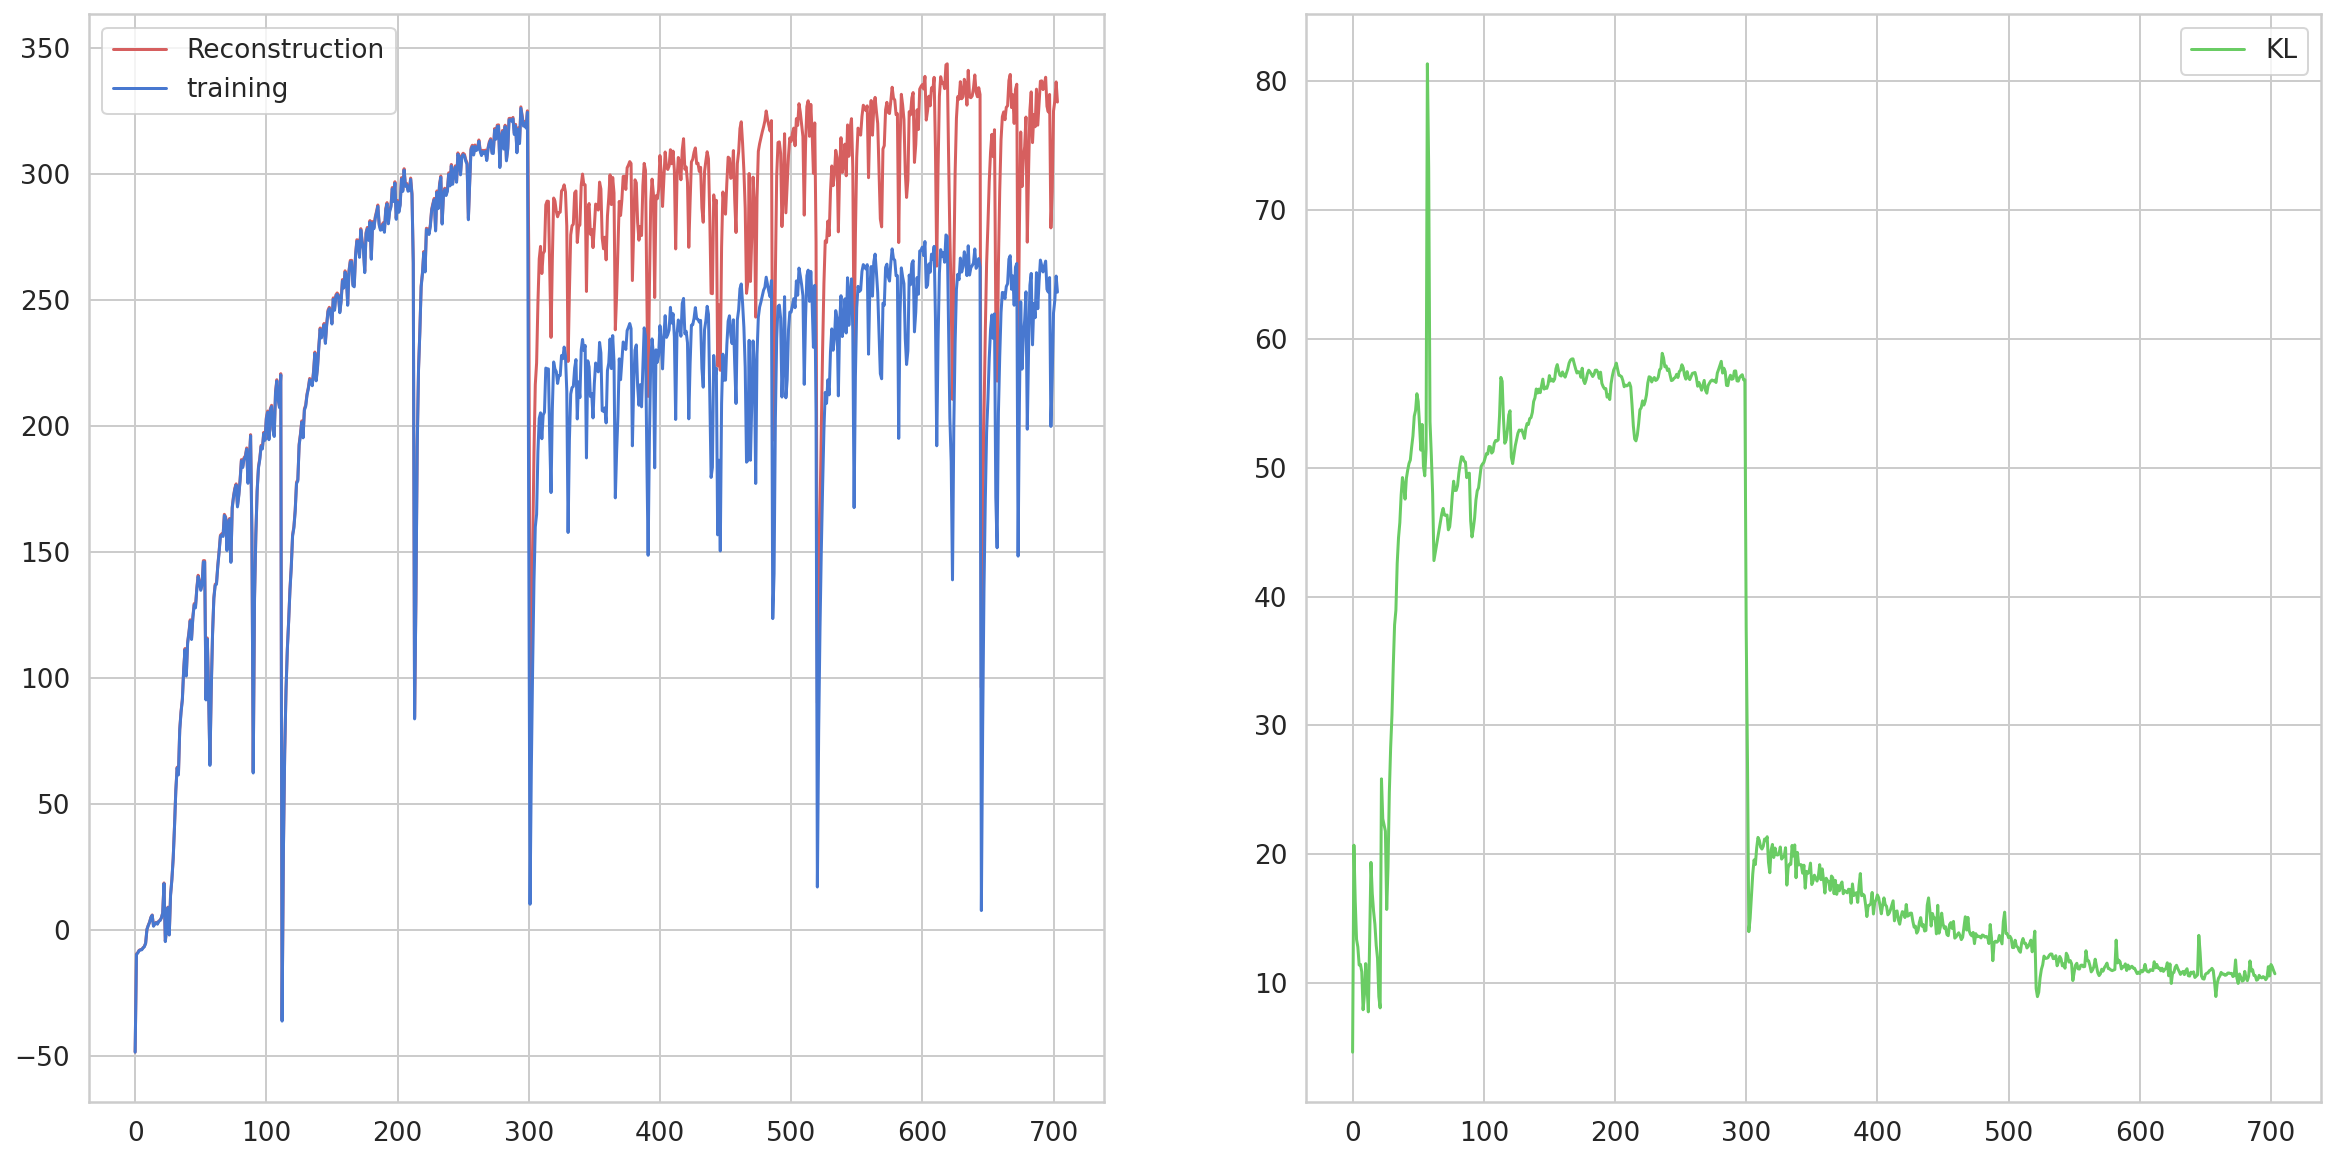

In [315]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

#ax[0].plot(list(range(len(VAL_LOSS_LIST))), VAL_LOSS_LIST, c='y', label="validation")
ax[0].plot(list(range(len(RECON_LOSS_LIST))), RECON_LOSS_LIST, c='r', label="Reconstruction")
ax[0].plot(list(range(len(LOSS_LIST))), LOSS_LIST, c='b', label="training")
ax[1].plot(list(range(len(KL_LOSS_LIST))), KL_LOSS_LIST, c='g', label="KL")
ax[0].legend()
ax[1].legend()

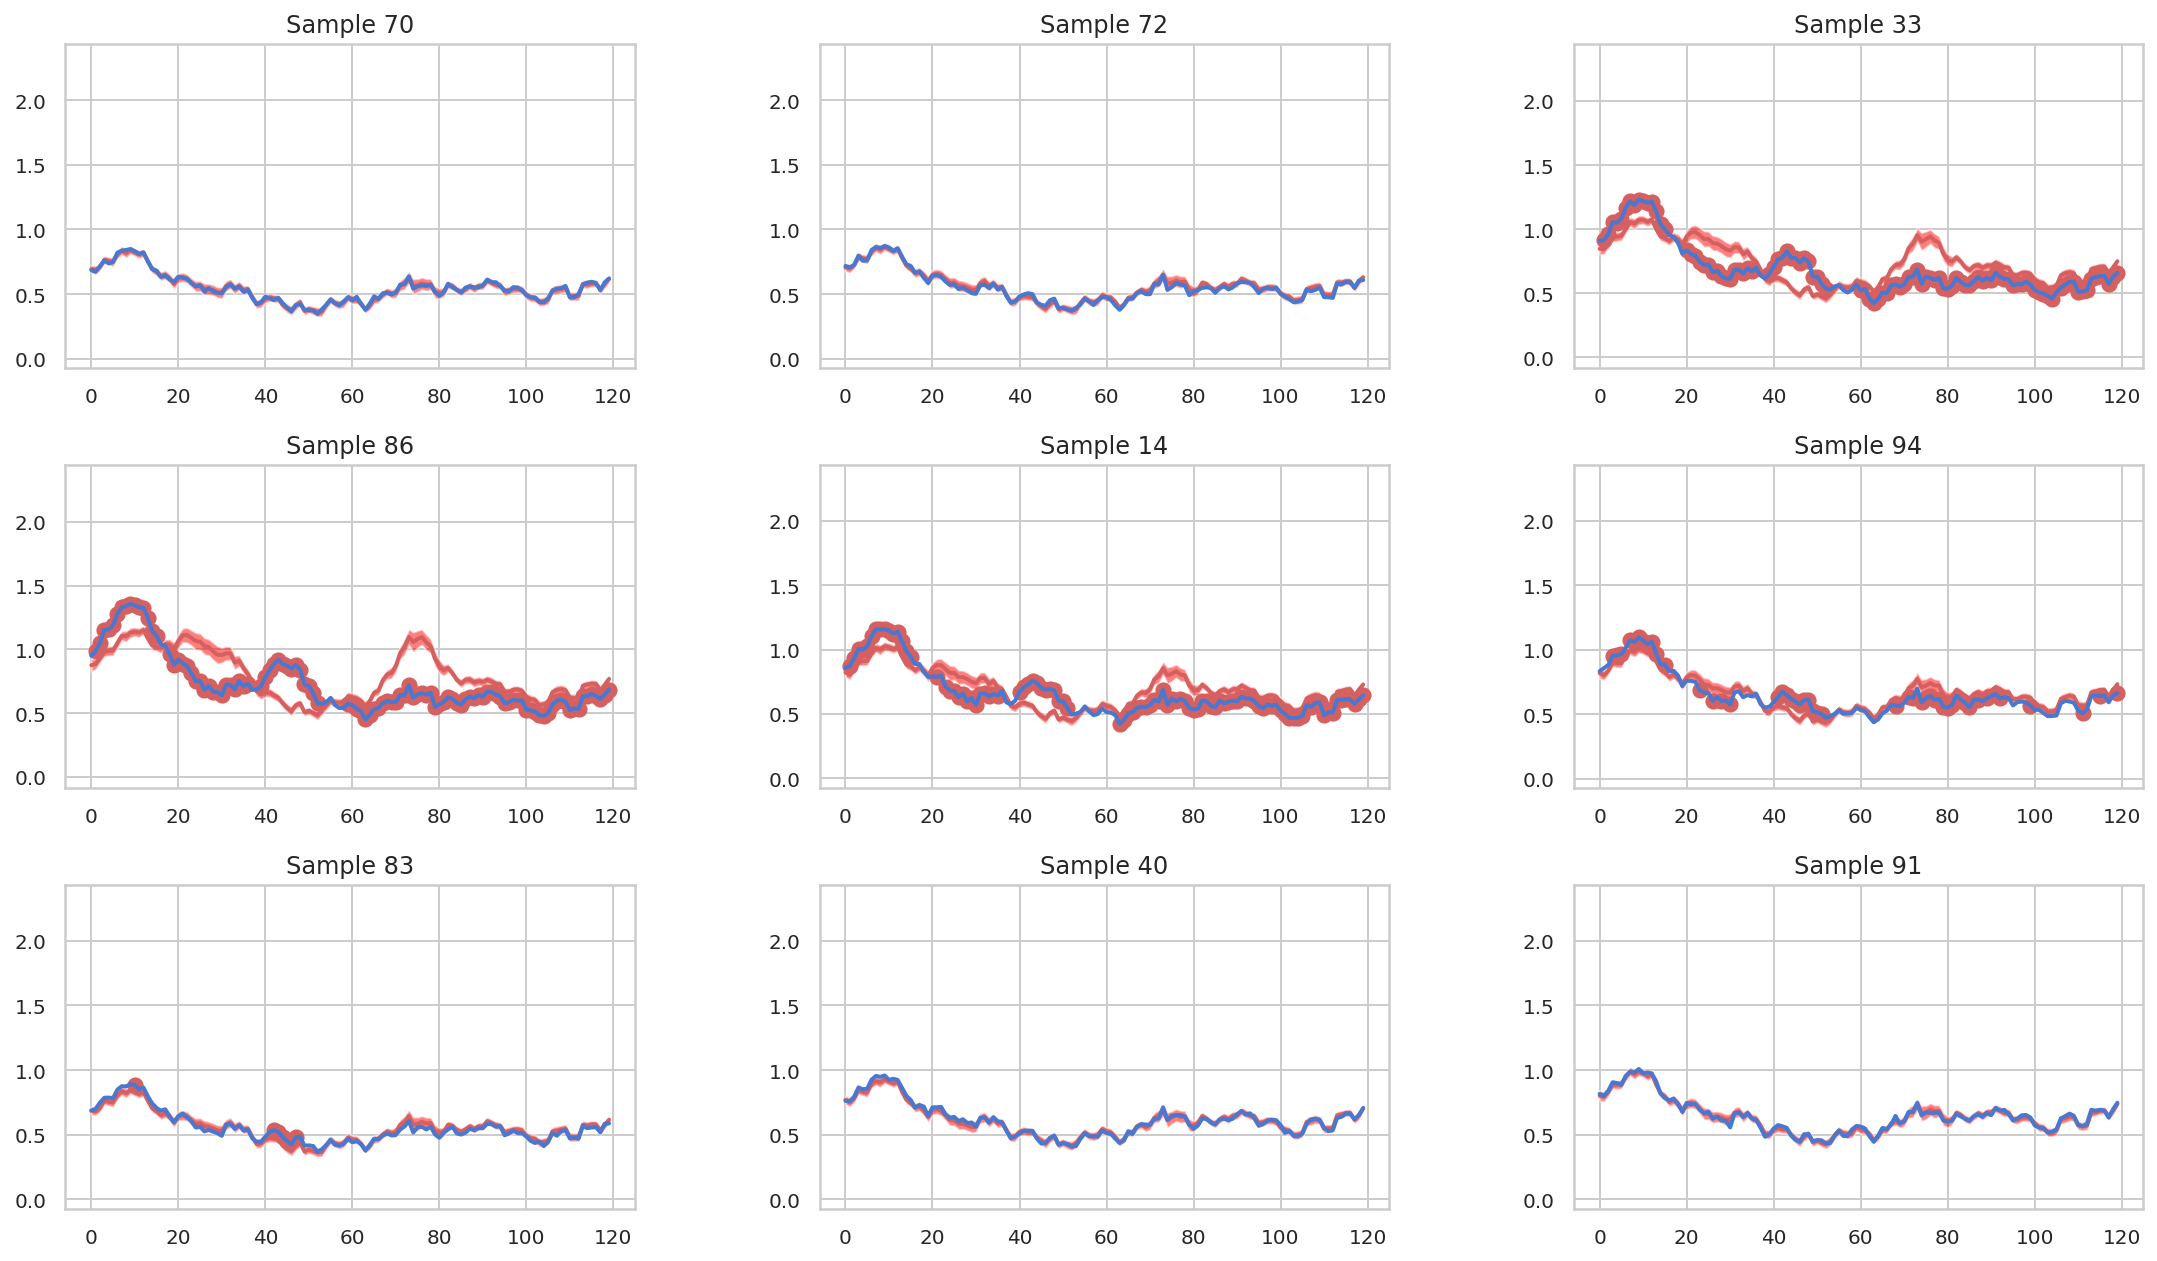

In [319]:
NUM_PLOTS = 9
#PLOT_DATA = train_dataset[:500]
PLOT_DATA = outlier_dataset[:500]
max_val = train_dataset.max()
min_val = train_dataset.min()
samples = np.random.choice(len(PLOT_DATA), replace=False, size=NUM_PLOTS)
fig, axes = plt.subplots(nrows=int(np.sqrt(NUM_PLOTS)), ncols=int(np.sqrt(NUM_PLOTS)))
fig.tight_layout()
fig.set_size_inches(16, 9)
ANOMALY_THRESHOLD = 0.1
for i, ax in enumerate(axes.flat):


    dataset_idx = samples[i]
        
    dat = PLOT_DATA[dataset_idx].to(device).unsqueeze(0)
    outputs = model.forward(dat)

    log_probs = outputs["px"].log_prob(dat.view(-1)).exp().detach().cpu().numpy()
    idx = log_probs < ANOMALY_THRESHOLD
    anom = np.arange(len(PLOT_DATA[dataset_idx]))[idx.squeeze()]
    
    mu = outputs["px"].mu.view(-1).detach().cpu().numpy()
    sigma = outputs["px"].sigma.view(-1).detach().cpu().numpy()
    ax.plot(mu, c="r", linewidth=2)
    ax.fill_between(list(range(len(mu))), mu-2*sigma, mu+2*sigma, facecolor='red', alpha=0.5)
    ax.plot(dat.view(-1).detach().cpu().numpy(), c="b", linewidth=2)
    ax.scatter(anom, dat.view(-1).detach().cpu().numpy()[anom], c="r", s=50, label="anomaly")
    
    ax.set_title(f"Sample {samples[i]}", fontdict={"size": 12})
    ax.set_ylim(min_val-2*sigma.max(), max_val+2*sigma.max())
    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)
plt.show();

In [322]:
outlier_dataset.shape

torch.Size([100, 120, 1])

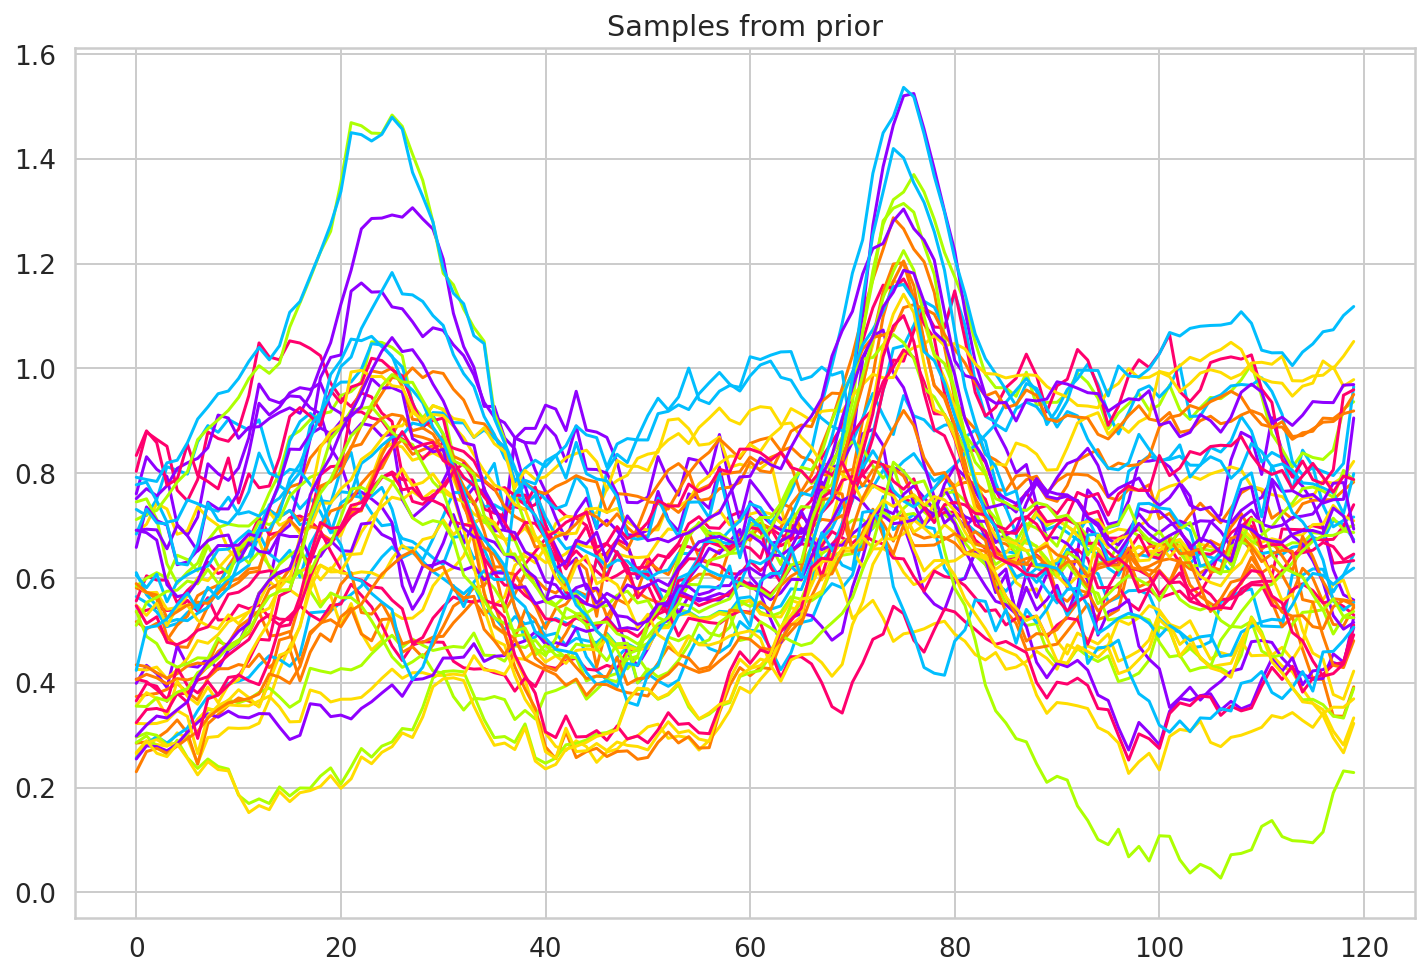

In [320]:
num_samples = 50
prior_samples = model.sample_from_prior(batch_size=num_samples)
for i in range(num_samples):
    plt.plot(prior_samples["px"].mu[i].detach().cpu())
plt.title("Samples from prior")
plt.show()